In [2]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep_v2, AugSynthGPT
from my_pysyncon.utils import PlaceboTest, date_to_str, winsorize_pre_int, boxcox_pre_int
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the data
df_mo = pd.read_csv('../../../SharedData/total_state_data_orig.csv')

# remove data post-2014-01-01
df_mo = df_mo[df_mo['date'] < '2014-01-01']

In [4]:
# this list is used to make certain columns later
abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [5]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = df_mo['total_facility_age'] / df_mo['monthly_num_plants']
df_mo['avg_weighted_facility_age'] = df_mo['total_weighted_facility_age'] / df_mo['monthly_num_plants'] 

## Transformation approach is to use pre-treatment data to transform both pre- and post-treatment data (to avoid data leakage). A given column's transformation is some combination of scale, winsorize, log/box-cox, and rolling average, in this order: <p align="center">scale -> winsorize -> log/box-cox -> rolling average </p>

In [6]:
# correct date formatting for masks below
df_mo['date_dt'] = pd.to_datetime(df_mo['date'])

# make masks for pre- and post-treatment, and drop na values
pre_mask = df_mo['date_dt'] < pd.to_datetime("2009-01-01")
post_mask = df_mo['date_dt'] >= pd.to_datetime("2009-01-01")
no_mask = df_mo['date_dt'] < pd.to_datetime("2014-01-01")

In [7]:
feats = ['co2_per_capita', 'gdp_per_capita', 'monthly_pop_density', 'snow', 'avg_weighted_facility_age', 'eprod_per_capita', 'euse_per_capita', 'monthly_coal_pct', 'monthly_fossil_pct', 'monthly_renew_pct']
df_mo_pre = df_mo[pre_mask]
print(f'Means before scaling:\n{df_mo[feats].mean()}\n')

# rescale features to be in range 0.01 <= y <= 10
df_mo['gdp_per_capita'] = df_mo['gdp_per_capita']*(10**3)
df_mo['monthly_pop_density'] = df_mo['monthly_pop_density']*(10**2)
df_mo['avg_weighted_facility_age'] = df_mo['avg_weighted_facility_age']/(10**7)
df_mo['eprod_per_capita'] = df_mo['eprod_per_capita']*(10**2)
df_mo['euse_per_capita'] = df_mo['euse_per_capita']*(10**2)
df_mo['monthly_coal_pct'] = df_mo['monthly_coal_pct']*(10**1)
df_mo['monthly_fossil_pct'] = df_mo['monthly_fossil_pct']*(10**1)
df_mo['monthly_renew_pct'] = df_mo['monthly_renew_pct']*(10**1)



print(f'Means after scaling:\n{df_mo[feats].mean()}')

Means before scaling:
co2_per_capita               1.026018e+00
gdp_per_capita               4.156120e-03
monthly_pop_density          2.624386e-02
snow                         2.391259e+00
avg_weighted_facility_age    2.033080e+07
eprod_per_capita             4.916647e-02
euse_per_capita              2.935926e-02
monthly_coal_pct             4.877078e-01
monthly_fossil_pct           6.724658e-01
monthly_renew_pct            1.199664e-01
dtype: float64

Means after scaling:
co2_per_capita               1.026018
gdp_per_capita               4.156120
monthly_pop_density          2.624386
snow                         2.391259
avg_weighted_facility_age    2.033080
eprod_per_capita             4.916647
euse_per_capita              2.935926
monthly_coal_pct             4.877078
monthly_fossil_pct           6.724658
monthly_renew_pct            1.199664
dtype: float64


In [8]:
# winsorize snow, energy use, and renewable energy %
df_mo['snow_wnsr'] = winsorize_pre_int(df_mo['snow'], pre_mask=pre_mask, limits=[0.00, 0.00])
df_mo['euse_per_capita_wnsr'] = winsorize_pre_int(df_mo['euse_per_capita'], pre_mask=pre_mask, limits=[0.00, 0.00])
df_mo['monthly_renew_pct_wnsr'] = winsorize_pre_int(df_mo['monthly_renew_pct'], pre_mask=pre_mask, limits=[0.00, 0.00])
df_mo['monthly_coal_pct_wnsr'] = winsorize_pre_int(df_mo['monthly_coal_pct'], pre_mask=pre_mask, limits=[0.00, 0.00])

# see how the data changes
#print(df_mo['euse_per_capita'].describe())
#print(df_mo['euse_per_capita_wnsr'].describe())
#print(df_mo['snow'].describe())
#print(df_mo['snow_wnsr'].describe())
#print(df_mo['monthly_renew_pct'].describe())
#print(df_mo['monthly_renew_pct_wnsr'].describe())
#print(df_mo['monthly_coal_pct'].describe())
#print(df_mo['monthly_coal_pct_wnsr'].describe())

In [9]:
# box-cox certain features to reduce skewness
box_cox_feats = ['eprod_per_capita', 'euse_per_capita', 'euse_per_capita_wnsr', 'gdp_per_capita', 'monthly_pop_density', 'snow_wnsr', 'monthly_coal_pct', 'avg_weighted_facility_age', 'monthly_renew_pct_wnsr', 'co2_per_capita','monthly_coal_pct_wnsr']

df_mo = boxcox_pre_int(df_mo, box_cox_feats, pre_mask=pre_mask, post_mask=post_mask)


Feature: eprod_per_capita
Minimum value (non-NA) before shift: 0.006499259506750783
Optimal lambda for Box-Cox transformation: -0.04140509068458145

Feature: euse_per_capita
Minimum value (non-NA) before shift: 1.5335806638911138
Optimal lambda for Box-Cox transformation: -0.9040001926681619

Feature: euse_per_capita_wnsr
Minimum value (non-NA) before shift: 1.5335806638911138
Optimal lambda for Box-Cox transformation: -0.9040001926681619

Feature: gdp_per_capita
Minimum value (non-NA) before shift: 2.607728533903031
Optimal lambda for Box-Cox transformation: -0.6612385698546107

Feature: monthly_pop_density
Minimum value (non-NA) before shift: 0.09987008415789
Optimal lambda for Box-Cox transformation: -0.060413244551690504

Feature: snow_wnsr
Minimum value (non-NA) before shift: 0.0
Optimal lambda for Box-Cox transformation: -0.1855056982044913

Feature: monthly_coal_pct
Minimum value (non-NA) before shift: 0.0
Optimal lambda for Box-Cox transformation: 0.5035684096005745

Feature: 

In [10]:
sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct','monthly_energy_coal', 'yearly_energy_coal', 'monthly_coal_pct',
       'yearly_coal_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age', 'total_weighted_facility_age','avg_weighted_facility_age',
       'eprod_per_capita_boxcox', 'euse_per_capita', 'euse_per_capita_wnsr', 'gdp_per_capita_boxcox',
       'monthly_pop_density_boxcox', 'snow_wnsr_boxcox', 'avg_weighted_facility_age_boxcox',
       'monthly_renew_pct_wnsr_boxcox', 'euse_per_capita_wnsr', 'euse_per_capita_boxcox', 'co2_per_capita_boxcox', 
       'snow_wnsr', 'monthly_renew_pct_wnsr', 'monthly_coal_pct_wnsr', 'monthly_coal_pct_wnsr_boxcox']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)
df_mo['co2_per_capita_sma']= np.nan
ma_window = 12

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()


# RGGI's first auction was 2009-01, and pre-treatment data extends back to 1990-01.
treatment_date = '2009-01-01'
start_date = '1991-01-01'
preintervention_ma_start_date = str((pd.to_datetime(start_date)+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))
start_year = pd.to_datetime(preintervention_ma_start_date).year
end_year = pd.to_datetime(treatment_date).year-1

# these are the time values where our pre-treatment features and CO2 outcomes are fit
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2013-12-01', freq='MS').strftime('%Y-%m-%d').tolist()
years_sma_pre_treat = pd.date_range(start=preintervention_ma_start_date, end='2008-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [11]:
# we exclude non-RGGI states with no CO2 data (AK, HI); states with some strong emissions program (CA, WA, OR, MN, IL)
# we exclude RGGI states with partial RGGI participation (NJ), and those without coal-fired power plants (VT, RI)
# SHOULD WE EXCLUDE VA because of RGGI adjacency?
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']    

non_rggi_controls_identifier = ["AL", "AR", "AZ", "CO", "FL", "GA", "ID", "IN", "IA", "KS", "KY", "LA", "MI", 
                               "MS", "MO", "MT", "NE", "NV", "NM", "NC", "ND", "OH", "OK", "PA",
                               "SC", "SD", "TN", "TX", "UT", "VA", "WV", "WI", "WY"
                            ]

In [12]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

# this date format is needed to specify time ranges in Dataprep below
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)

In [13]:
# dictionary to store the proposed year - before - when RGGI first started having an impact in each state
# this is used in 'co2_per_capita_boxcox_sma' predictor in Dataprep_v2 below

effects_dict = {'NY':2005, 'MD':2006, 'ME':2005, 'DE':2005, 'MA':2006, 'NH':2006, 'CT':2005}

In [14]:
# define normalized R-squared function:
def normalized_r_squared(actual, preds):
    return 1 - ((actual - preds)**2).sum() / ((actual - actual.mean())**2).sum()

In [15]:
raise ValueError('stop')

ValueError: stop

In [ ]:
# create a Dataprep object which contains information about covariates/predictors and outcomes/dependents

for state in rggi_states:

    dataprep_mo_ma = Dataprep_v2(
        foo = df_mo,
        predictors = [],
        predictors_op = "mean",
        time_predictors_prior = preintervention_ma_range,
        special_predictors = [
            ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= effects_dict[state]-1) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
            ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == effects_dict[state]) & (preintervention_ma_range_dt.dt.month == 12)]), 'mean'),
            ('gdp_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year<= end_year)]), 'mean'),
            ('monthly_pop_density_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), "mean"),            
            ('snow_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),            
            ('avg_weighted_facility_age_sma',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == 2008) & ((preintervention_ma_range_dt.dt.month == 6) | (preintervention_ma_range_dt.dt.month == 12))]), 'mean'),   #_boxcox                           
            ('eprod_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'), 
            ('euse_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'),                 
            ('monthly_coal_pct_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
            ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),         
            ('monthly_renew_pct_wnsr_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean')    
            ],
        dependent = "co2_per_capita_boxcox_sma",
        unit_variable = "state",
        time_variable = "date",
        treatment_identifier = state,
        controls_identifier = non_rggi_controls_identifier,
        time_optimize_ssr = preintervention_ma_range
        )

    # fit the model
    synth_mo_ma = AugSynthGPT()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    print(synth_mo_ma.weights(threshold = .1))
    print('Regularization lambda =', synth_mo_ma.lambda_)
    print('Pre-treatment MSE =', synth_mo_ma.mspe(Z0 = synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))

    Z0,Z1=dataprep_mo_ma.make_outcome_mats(time_period=years_sma) # Get the dataframe of pre-treatment outcome values for the donor pool and the experimental subject
    ts_synth=synth_mo_ma._synthetic(Z0) # Get the pre-treatment synthetic control fitted values

    ts_synth_pre_treat=ts_synth[ts_synth.index < treatment_date] # Restrict to pre-intervention period
    Z1_pre_treat = Z1[Z1.index < treatment_date] 

    r_squared = normalized_r_squared(actual=Z1_pre_treat.values, preds=ts_synth_pre_treat.values).round(3)
    print(f"The normalized r-squared value for {state} is:", (r_squared))

    # display the V matrix weights and distribution info
    display(synth_mo_ma.summary_with_variance(round = 3))

    # plot the synthetic vs actual
    synth_mo_ma.path_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])

CO    1.194
FL    0.958
GA    0.834
IA    0.325
MT    0.106
NM    0.491
PA    1.271
SC    0.744
SD    0.145
TN    0.170
TX    1.116
WI    0.855
WY    0.492
Name: weights, dtype: float64
Regularization lambda = 0.0044441172900676765
Pre-treatment MSE = 0.0006821155453170568
The normalized r-squared value for CT is: 0.942


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.000,-1.230,-1.230,0.041,0.848,0.051
special.2.co2_per_capita_boxcox_sma,0.921,-1.234,-1.287,0.105,0.735,0.680
special.3.gdp_per_capita_sma,0.000,5.834,5.831,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.079,-1.920,-1.915,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,2.527,2.523,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.000,0.474,0.477,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.000,-0.879,-0.897,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.000,0.516,0.517,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.000,1.279,1.330,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,4.593,4.592,7.487,4.224,-1.195


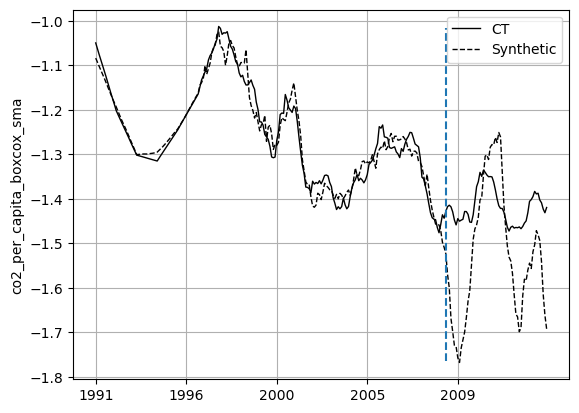

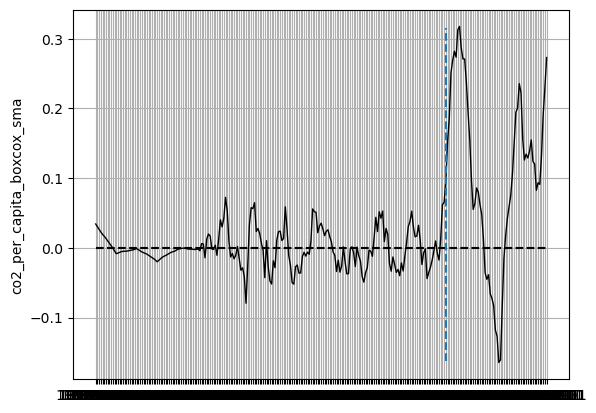

Now performing placebo test for: CT
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AZ.
(3/33) Completed placebo test for FL.
(4/33) Completed placebo test for AL.
(5/33) Completed placebo test for CO.
(6/33) Completed placebo test for GA.
(7/33) Completed placebo test for AR.
(8/33) Completed placebo test for IN.
(9/33) Completed placebo test for KS.
(10/33) Completed placebo test for IA.
(11/33) Completed placebo test for KY.
(12/33) Completed placebo test for MI.
(13/33) Completed placebo test for MS.
(14/33) Completed placebo test for LA.
(15/33) Completed placebo test for MO.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NV.
(18/33) Completed placebo test for NE.
(19/33) Completed placebo test for ND.
(20/33) Completed placebo test for NM.
(21/33) Completed placebo test for NC.
(22/33) Completed placebo test for OK.
(23/33) Completed placebo test for OH.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

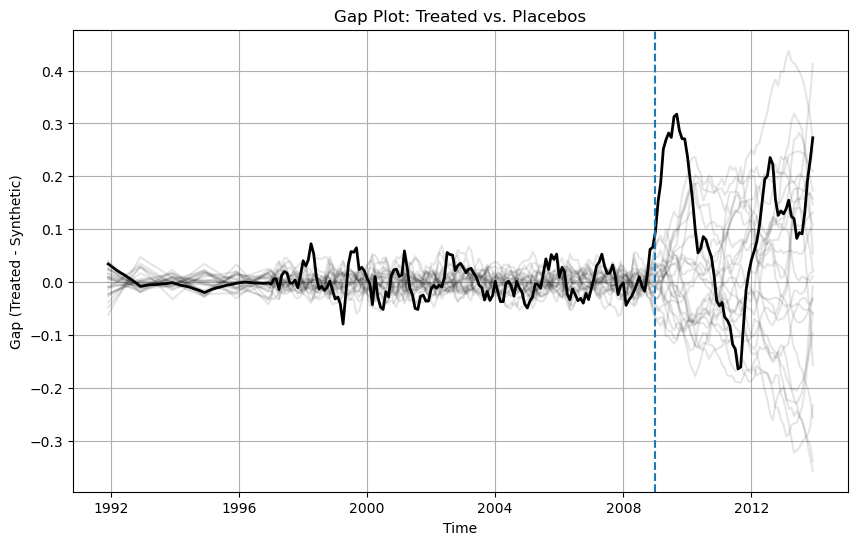

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
AZ    0.509
CO    0.344
FL    0.285
IA    1.433
KS    0.227
MI    1.009
NM    0.249
ND    0.540
OH    1.328
PA    0.254
TN    0.784
TX    0.166
WI    0.420
WY    0.585
Name: weights, dtype: float64
Regularization lambda = 0.011163117920958119
Pre-treatment MSE = 0.0020040285621182774
The normalized r-squared value for DE is: 0.929


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.114,-0.267,-0.269,0.041,0.848,0.051
special.2.co2_per_capita_boxcox_sma,0.000,-0.442,-0.434,0.105,0.735,0.680
special.3.gdp_per_capita_sma,0.006,6.525,6.529,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.003,-1.443,-1.458,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.001,0.861,0.839,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.000,1.061,1.075,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.007,-4.333,-4.256,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.000,0.695,0.692,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.864,5.695,5.655,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,9.649,9.691,7.487,4.224,-1.195


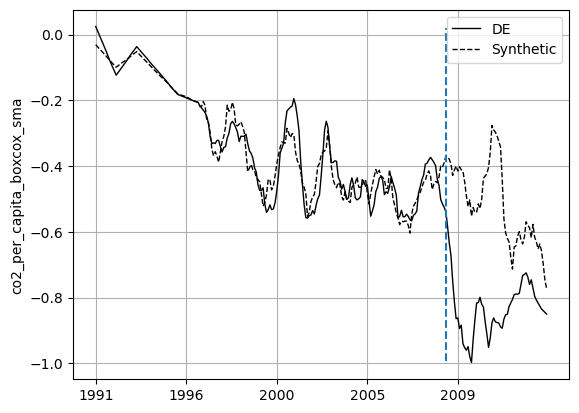

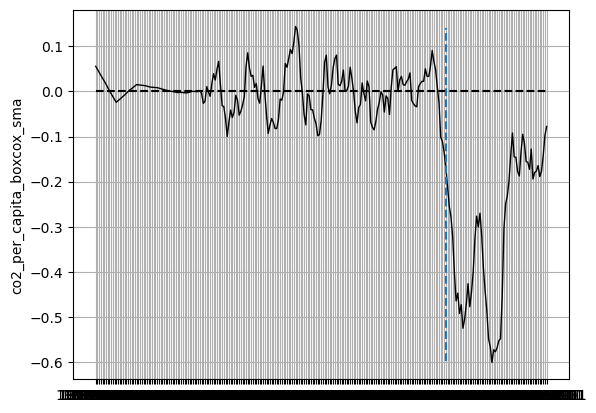

Now performing placebo test for: DE
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AZ.
(3/33) Completed placebo test for FL.
(4/33) Completed placebo test for AL.
(5/33) Completed placebo test for CO.
(6/33) Completed placebo test for AR.
(7/33) Completed placebo test for GA.
(8/33) Completed placebo test for IN.
(9/33) Completed placebo test for IA.
(10/33) Completed placebo test for KS.
(11/33) Completed placebo test for KY.
(12/33) Completed placebo test for MI.
(13/33) Completed placebo test for MS.
(14/33) Completed placebo test for MO.
(15/33) Completed placebo test for MT.
(16/33) Completed placebo test for LA.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for ND.
(20/33) Completed placebo test for NC.
(21/33) Completed placebo test for NM.
(22/33) Completed placebo test for OK.
(23/33) Completed placebo test for OH.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

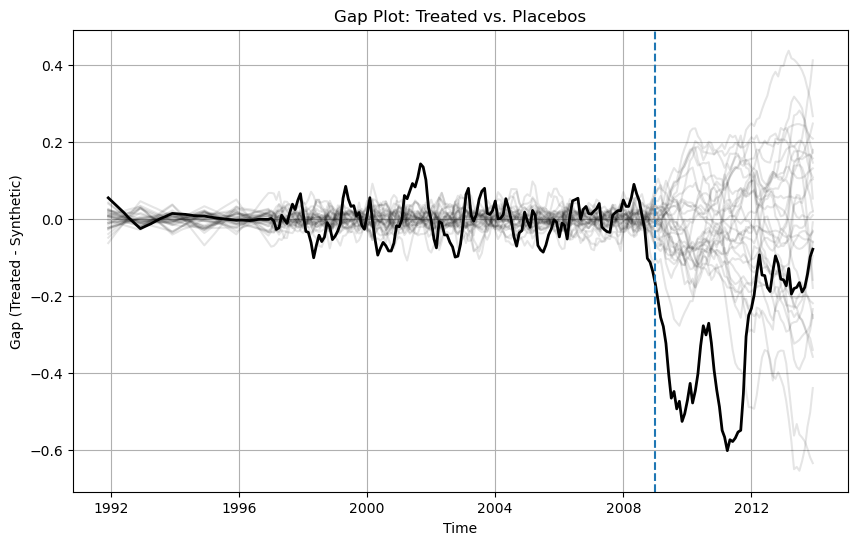

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
AZ    0.364
FL    1.063
ID    0.273
IA    0.346
KS    1.117
LA    0.461
MO    1.217
MT    0.743
ND    0.721
OH    0.994
OK    0.164
PA    0.456
SC    0.511
TN    0.780
TX    0.177
VA    1.011
Name: weights, dtype: float64
Regularization lambda = 0.011163117920958119
Pre-treatment MSE = 0.0029547408412097576
The normalized r-squared value for ME is: 0.976


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.000,-1.491,-1.492,0.041,0.848,0.051
special.2.co2_per_capita_boxcox_sma,0.035,-1.066,-1.079,0.105,0.735,0.680
special.3.gdp_per_capita_sma,0.000,3.558,3.559,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.000,0.988,1.005,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,5.662,5.605,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.002,0.868,0.848,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.000,-0.056,-0.038,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.636,0.663,0.662,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.023,0.351,0.367,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,3.969,4.032,7.487,4.224,-1.195


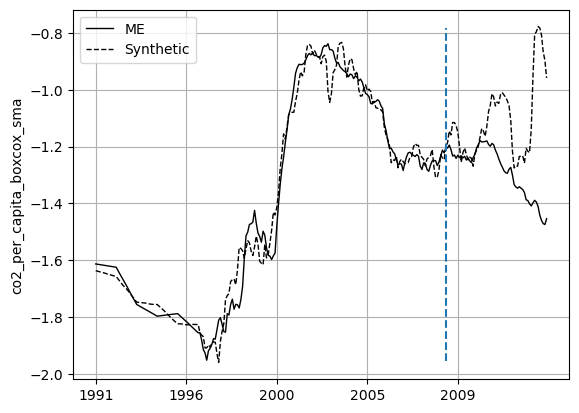

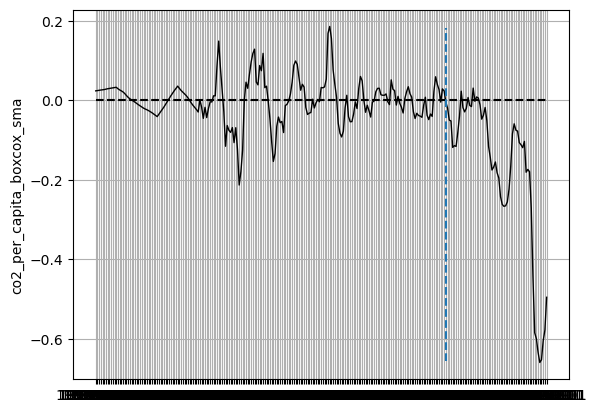

Now performing placebo test for: ME
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AZ.
(3/33) Completed placebo test for FL.
(4/33) Completed placebo test for AL.
(5/33) Completed placebo test for CO.
(6/33) Completed placebo test for GA.
(7/33) Completed placebo test for IN.
(8/33) Completed placebo test for KS.
(9/33) Completed placebo test for AR.
(10/33) Completed placebo test for IA.
(11/33) Completed placebo test for KY.
(12/33) Completed placebo test for MI.
(13/33) Completed placebo test for LA.
(14/33) Completed placebo test for MS.
(15/33) Completed placebo test for MO.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for ND.
(20/33) Completed placebo test for NM.
(21/33) Completed placebo test for NC.
(22/33) Completed placebo test for OH.
(23/33) Completed placebo test for OK.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

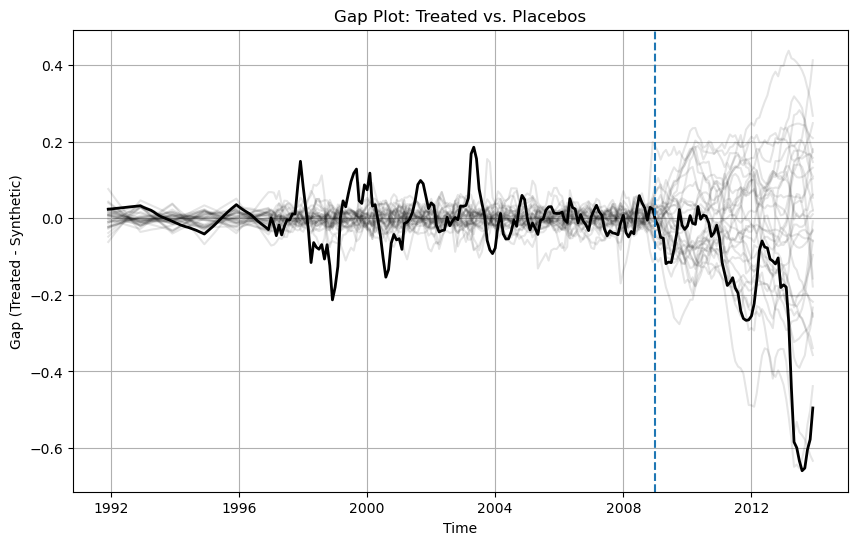

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
FL    0.292
GA    0.158
KY    0.461
MI    0.204
MO    0.220
MT    0.133
ND    0.190
PA    0.108
TX    0.319
VA    0.610
WV    0.141
Name: weights, dtype: float64
Regularization lambda = 0.011161967841534186
Pre-treatment MSE = 0.0001450498663292473
The normalized r-squared value for MD is: 0.972


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.000,-0.632,-0.632,0.045,0.837,0.100
special.2.co2_per_capita_boxcox_sma,0.881,-0.761,-0.766,0.074,0.755,0.529
special.3.gdp_per_capita_sma,0.000,4.472,4.471,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.087,-1.516,-1.513,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,1.574,1.574,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.000,2.926,2.914,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.000,-0.863,-0.869,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.000,0.566,0.566,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.000,5.810,5.813,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.032,6.703,6.684,7.487,4.224,-1.195


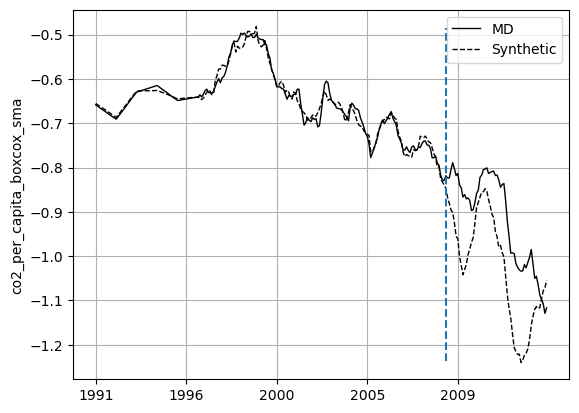

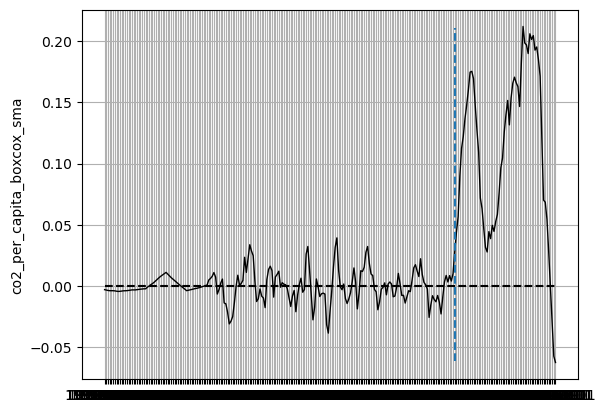

Now performing placebo test for: MD
made it here
(1/33) Completed placebo test for AR.
(2/33) Completed placebo test for ID.
(3/33) Completed placebo test for AZ.
(4/33) Completed placebo test for IN.
(5/33) Completed placebo test for GA.
(6/33) Completed placebo test for FL.
(7/33) Completed placebo test for AL.
(8/33) Completed placebo test for CO.
(9/33) Completed placebo test for IA.
(10/33) Completed placebo test for KS.
(11/33) Completed placebo test for MI.
(12/33) Completed placebo test for KY.
(13/33) Completed placebo test for LA.
(14/33) Completed placebo test for MO.
(15/33) Completed placebo test for MS.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for NM.
(20/33) Completed placebo test for NC.
(21/33) Completed placebo test for ND.
(22/33) Completed placebo test for OH.
(23/33) Completed placebo test for OK.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

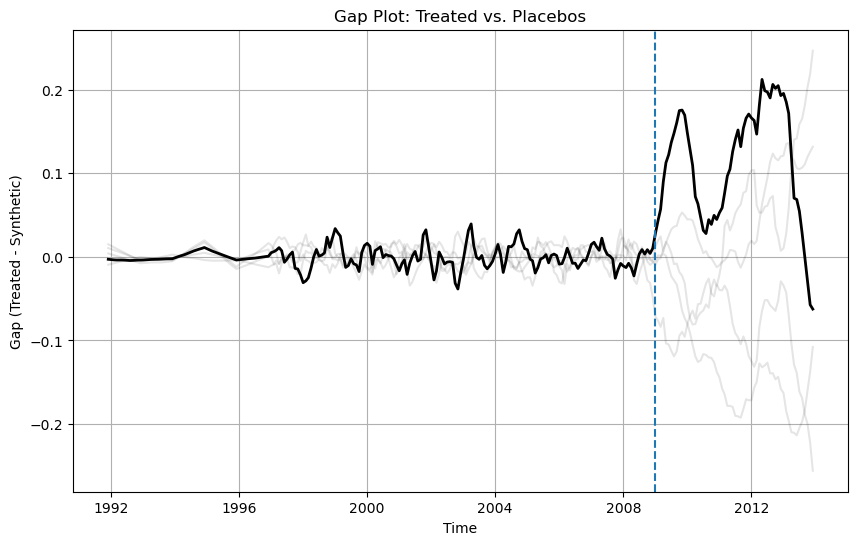

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
AL    0.136
AZ    0.306
CO    0.704
FL    0.576
IA    0.139
KY    0.295
MO    0.670
MT    0.139
ND    0.247
PA    0.426
TX    1.023
VA    0.355
WI    0.901
Name: weights, dtype: float64
Regularization lambda = 0.011161967841534186
Pre-treatment MSE = 0.0004940838540195213
The normalized r-squared value for MA is: 0.908


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.143,-0.985,-0.986,0.045,0.837,0.100
special.2.co2_per_capita_boxcox_sma,0.807,-1.040,-1.027,0.074,0.755,0.529
special.3.gdp_per_capita_sma,0.000,5.127,5.123,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.050,-1.883,-1.878,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,4.068,4.062,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.000,1.183,1.176,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.000,-2.048,-2.035,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.000,0.495,0.495,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.000,2.676,2.727,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,8.233,8.189,7.487,4.224,-1.195


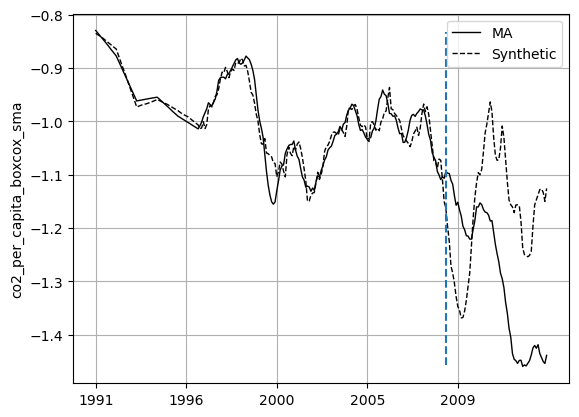

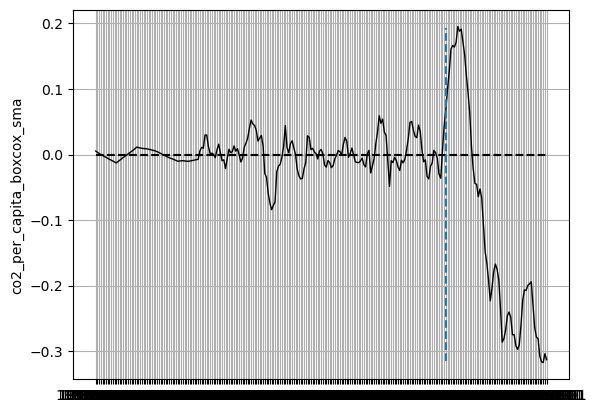

Now performing placebo test for: MA
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AR.
(3/33) Completed placebo test for AZ.
(4/33) Completed placebo test for IN.
(5/33) Completed placebo test for GA.
(6/33) Completed placebo test for FL.
(7/33) Completed placebo test for AL.
(8/33) Completed placebo test for IA.
(9/33) Completed placebo test for CO.
(10/33) Completed placebo test for KY.
(11/33) Completed placebo test for MI.
(12/33) Completed placebo test for KS.
(13/33) Completed placebo test for LA.
(14/33) Completed placebo test for MO.
(15/33) Completed placebo test for MS.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for NM.
(20/33) Completed placebo test for NC.
(21/33) Completed placebo test for ND.
(22/33) Completed placebo test for OH.
(23/33) Completed placebo test for OK.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

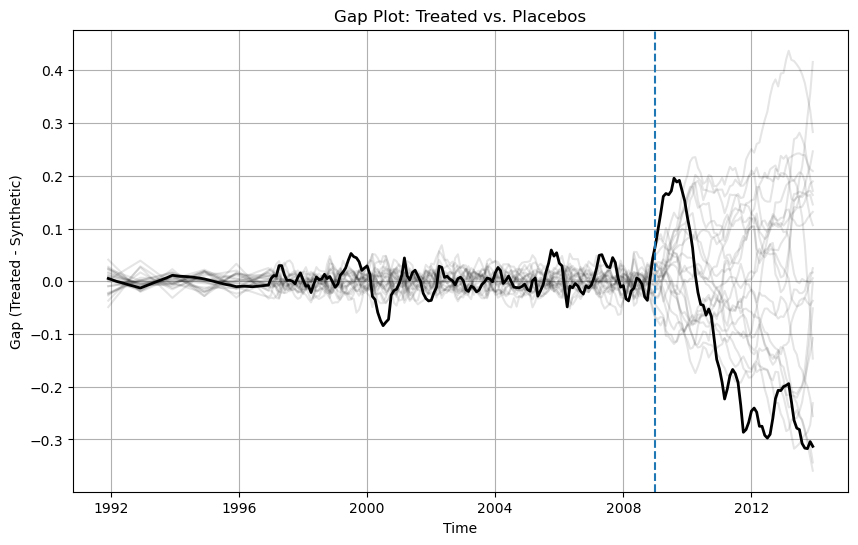

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
AL    1.267
AZ    0.113
FL    0.510
KS    0.576
KY    0.609
LA    0.531
MO    0.974
MT    0.294
OH    0.482
PA    1.640
SC    0.241
TX    0.229
UT    2.571
VA    0.197
WI    4.130
WY    0.255
Name: weights, dtype: float64
Regularization lambda = 0.0017690526846517402
Pre-treatment MSE = 0.0011545344756605288
The normalized r-squared value for NH is: 0.952


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.058,-0.850,-0.854,0.045,0.837,0.100
special.2.co2_per_capita_boxcox_sma,0.000,-0.685,-0.667,0.074,0.755,0.529
special.3.gdp_per_capita_sma,0.000,4.208,4.207,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.622,-0.270,-0.267,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,22.809,22.765,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.000,1.704,1.674,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.310,-0.213,-0.200,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.005,0.500,0.500,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.005,2.105,2.154,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,3.551,3.558,7.487,4.224,-1.195


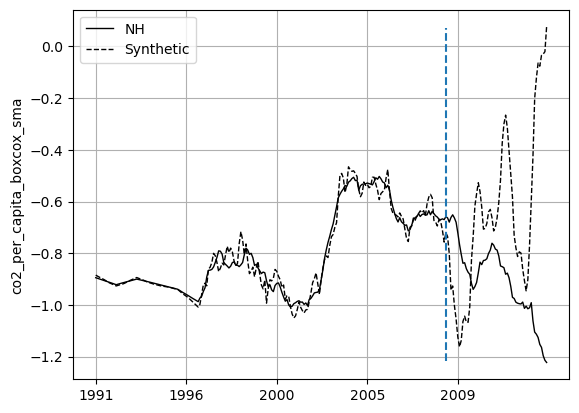

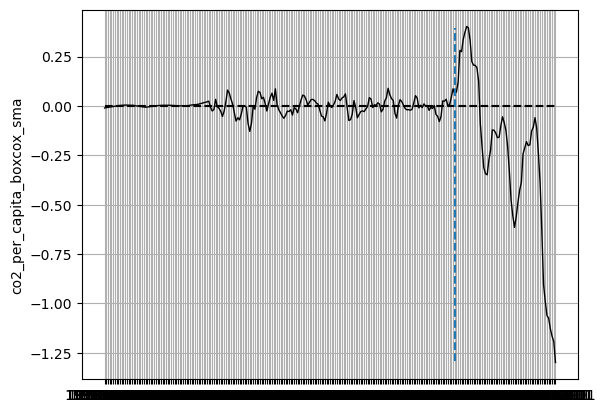

Now performing placebo test for: NH
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AR.
(3/33) Completed placebo test for AZ.
(4/33) Completed placebo test for GA.
(5/33) Completed placebo test for IN.
(6/33) Completed placebo test for FL.
(7/33) Completed placebo test for AL.
(8/33) Completed placebo test for IA.
(9/33) Completed placebo test for CO.
(10/33) Completed placebo test for KS.
(11/33) Completed placebo test for KY.
(12/33) Completed placebo test for MI.
(13/33) Completed placebo test for LA.
(14/33) Completed placebo test for MO.
(15/33) Completed placebo test for MS.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for NM.
(20/33) Completed placebo test for NC.
(21/33) Completed placebo test for ND.
(22/33) Completed placebo test for OK.
(23/33) Completed placebo test for OH.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

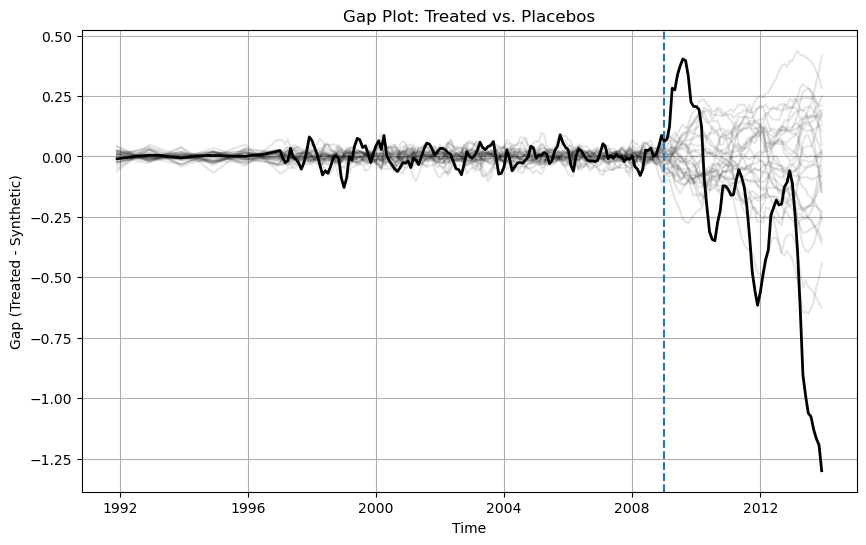

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------
AL    0.485
CO    0.633
FL    0.994
GA    0.838
IA    0.301
KY    0.466
LA    0.160
MO    0.166
MT    0.124
NV    0.176
PA    0.630
SD    0.187
TX    0.183
VA    0.306
Name: weights, dtype: float64
Regularization lambda = 0.0044441172900676765
Pre-treatment MSE = 0.0003768504334103959
The normalized r-squared value for NY is: 0.9


,V,Treated,Synthetic,Sample Mean,Variance,Skewness
special.1.co2_per_capita_boxcox_sma,0.000,-1.186,-1.187,0.041,0.848,0.051
special.2.co2_per_capita_boxcox_sma,0.767,-1.195,-1.190,0.105,0.735,0.680
special.3.gdp_per_capita_sma,0.000,5.440,5.437,3.800,0.250,0.164
special.4.monthly_pop_density_boxcox_sma,0.130,-1.288,-1.284,0.582,1.053,0.464
special.5.snow_wnsr_sma,0.000,1.996,1.991,1.510,2.735,0.951
special.6.avg_weighted_facility_age_sma,0.081,0.824,0.810,3.166,2.553,0.557
special.7.eprod_per_capita_boxcox_sma,0.000,-1.350,-1.371,0.449,2.066,0.472
special.8.euse_per_capita_boxcox_sma,0.008,0.411,0.412,0.702,0.009,0.463
special.9.monthly_coal_pct_wnsr_sma,0.000,1.721,1.737,6.346,5.632,-0.423
special.10.monthly_fossil_pct_sma,0.000,5.420,5.400,7.487,4.224,-1.195


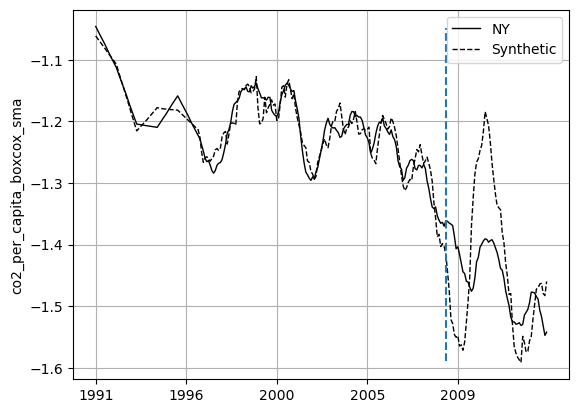

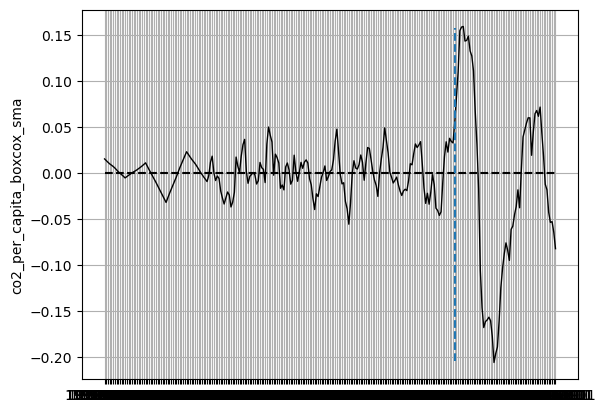

Now performing placebo test for: NY
made it here
(1/33) Completed placebo test for ID.
(2/33) Completed placebo test for AZ.
(3/33) Completed placebo test for FL.
(4/33) Completed placebo test for CO.
(5/33) Completed placebo test for AL.
(6/33) Completed placebo test for IN.
(7/33) Completed placebo test for GA.
(8/33) Completed placebo test for AR.
(9/33) Completed placebo test for IA.
(10/33) Completed placebo test for KS.
(11/33) Completed placebo test for MI.
(12/33) Completed placebo test for LA.
(13/33) Completed placebo test for MS.
(14/33) Completed placebo test for KY.
(15/33) Completed placebo test for MO.
(16/33) Completed placebo test for MT.
(17/33) Completed placebo test for NE.
(18/33) Completed placebo test for NV.
(19/33) Completed placebo test for ND.
(20/33) Completed placebo test for NC.
(21/33) Completed placebo test for NM.
(22/33) Completed placebo test for OK.
(23/33) Completed placebo test for OH.
(24/33) Completed placebo test for PA.
(25/33) Completed placeb

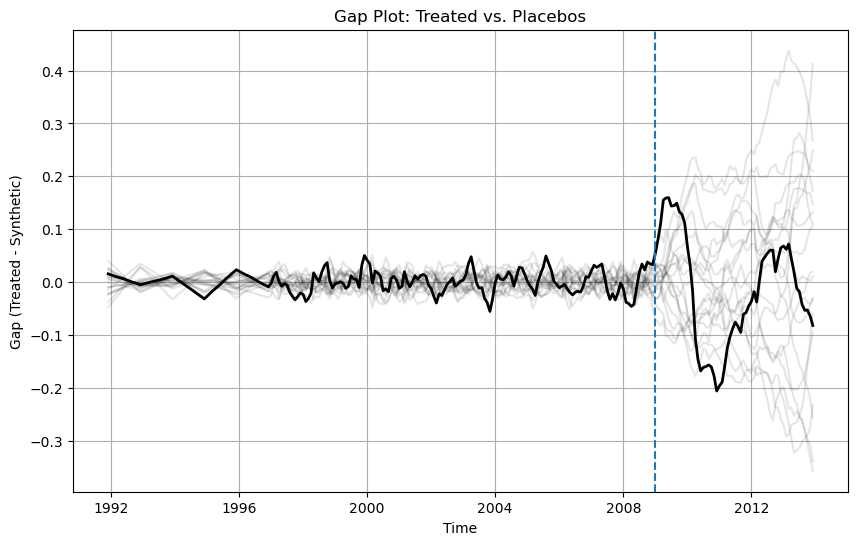

-------------------------------------------------------------------------------------------------------------------------
NEXT STATE
-------------------------------------------------------------------------------------------------------------------------


In [ ]:
# create a Dataprep object which contains information about covariates/predictors and outcomes/dependents

for state in rggi_states:

    dataprep_mo_ma = Dataprep_v2(
        foo = df_mo,
        predictors = [],
        predictors_op = "mean",
        time_predictors_prior = preintervention_ma_range,
        special_predictors = [
            ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= effects_dict[state]-1) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
            ('co2_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == effects_dict[state]) & (preintervention_ma_range_dt.dt.month == 12)]), 'mean'),
            ('gdp_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year<= end_year)]), 'mean'),
            ('monthly_pop_density_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), "mean"),            
            ('snow_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),            
            ('avg_weighted_facility_age_sma',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year == 2008) & ((preintervention_ma_range_dt.dt.month == 6) | (preintervention_ma_range_dt.dt.month == 12))]), 'mean'),   #_boxcox                           
            ('eprod_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'), 
            ('euse_per_capita_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year)]), 'mean'),                 
            ('monthly_coal_pct_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & (preintervention_ma_range_dt.dt.month == 3)]), 'mean'),
            ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),         
            ('monthly_renew_pct_wnsr_boxcox_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= start_year) & (preintervention_ma_range_dt.dt.year <= end_year) & ((preintervention_ma_range_dt.dt.month == 9))]), 'mean')    
            ],
        dependent = "co2_per_capita_boxcox_sma",
        unit_variable = "state",
        time_variable = "date",
        treatment_identifier = state,
        controls_identifier = non_rggi_controls_identifier,
        time_optimize_ssr = preintervention_ma_range
        )

    # fit the model
    synth_mo_ma = AugSynthGPT()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    print(synth_mo_ma.weights(threshold = .1))
    print('Regularization lambda =', synth_mo_ma.lambda_)
    print('Pre-treatment MSE =', synth_mo_ma.mspe(Z0 = synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))

    Z0,Z1=dataprep_mo_ma.make_outcome_mats(time_period=years_sma) # Get the dataframe of pre-treatment outcome values for the donor pool and the experimental subject
    ts_synth=synth_mo_ma._synthetic(Z0) # Get the pre-treatment synthetic control fitted values

    ts_synth_pre_treat=ts_synth[ts_synth.index < treatment_date] # Restrict to pre-intervention period
    Z1_pre_treat = Z1[Z1.index < treatment_date] 

    r_squared = normalized_r_squared(actual=Z1_pre_treat.values, preds=ts_synth_pre_treat.values).round(3)
    print(f"The normalized r-squared value for {state} is:", (r_squared))

    # display the V matrix weights and distribution info
    display(synth_mo_ma.summary_with_variance(round = 3))

    # plot the synthetic vs actual
    #synth_mo_ma.path_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])
    #synth_mo_ma.gaps_plot(time_period = years_sma_pre_treat, treatment_time = treatment_dates_ma[0])

    synth_mo_ma.path_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0])

    # perform the placebo tests
    print('Now performing placebo test for:', state)
    placebo_test = PlaceboTest()
    placebo_test.fit(
        dataprep=dataprep_mo_ma,
        scm=synth_mo_ma,
        scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"}, 
        max_workers = 8
    )
    # plot the placebo tests
    print('The p-value for',state,'is',placebo_test.pvalue(treatment_time = treatment_dates_ma[0]))
    placebo_test.gaps_plot(time_period = years_sma, treatment_time = treatment_dates_ma[0], mspe_threshold=1)

    print('-------------------------------------------------------------------------------------------------------------------------')
    print('NEXT STATE')
    print('-------------------------------------------------------------------------------------------------------------------------')